In [1]:
%pip install -e ..
%load_ext autoreload
%autoreload 2

Obtaining file:///C:/Users/USER/Desktop/projects/Health%20Insurance%20Model
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Checking if build backend supports build_editable: started
  Checking if build backend supports build_editable: finished with status 'done'
  Getting requirements to build editable: started
  Getting requirements to build editable: finished with status 'done'
  Preparing editable metadata (pyproject.toml): started
  Preparing editable metadata (pyproject.toml): finished with status 'done'
  Building editable for insurance (pyproject.toml): started
  Building editable for insurance (pyproject.toml): finished with status 'done'
  Created wheel for insurance: filename=insurance-0.1.0-0.editable-py3-none-any.whl size=1307 sha256=846b504e1b35486c4c919255fc0266e125e5e9b947235395821d6e2325c5d5de
  Stored in directory: C:\Users\USER\AppData\Local\Temp\pip-ephem-wheel-cache-aycov0a_\wheels\c7\86\56\d85e9c1741a69fba656


[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import sklearn, sys
assert sklearn.__version__.startswith("1.4"), \
    f"Wrong sklearn version: {sklearn.__version__}"

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns

from insurance.data.load import load_raw
from insurance.features.engineering import prepare_data
from insurance.features.risk_score import add_normalized_risk_score
from insurance.features.preprocessing import make_preprocessor




### Building Dataset

In [5]:
df = load_raw()           
df = prepare_data(df)
df = add_normalized_risk_score(df)

# label-encode plan & income level
df["insurance_plan"] = df["insurance_plan"].map({"Bronze": 1, "Silver": 2, "Gold": 3})
df["income_level"] = df["income_level"].map({"<10L": 1, "10L - 25L": 2, "25L - 40L": 3, "> 40L": 4})

#dropping income_level due to too high VIF
df = df.drop(columns=["income_level"])

df.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,6,Diabetes,1,9053,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,6,Diabetes,1,16339,diabetes,none,6,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,20,High blood pressure,2,18164,high blood pressure,none,6,0.428571
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,77,No Disease,3,20303,no disease,none,0,0.000000
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,99,High blood pressure,2,13365,high blood pressure,none,6,0.428571


### Model Training

In [6]:
X = df.drop(columns=["annual_premium_amount"])
y = df["annual_premium_amount"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocess = make_preprocessor()

In [7]:
models: dict[str, tuple[object, dict]] = {
    "Ridge": (
        Ridge(),
        {"model__alpha": [0.1, 1, 10]},
    ),
    "Lasso": (
        Lasso(max_iter=5000),
        {"model__alpha": [0.001, 0.01, 0.1]},
    ),
    "ElasticNet": (
        ElasticNet(max_iter=5000),
        {
            "model__alpha": [0.01, 0.1],
            "model__l1_ratio": [0.2, 0.5, 0.8],
        },
    ),
    "RandomForest": (
        RandomForestRegressor(random_state=42),
        {
            "model__n_estimators": [300],
            "model__max_depth": [None, 6, 10],
            "model__min_samples_leaf": [1, 3],
        },
    ),
    "GBR": (
        GradientBoostingRegressor(random_state=42),
        {
            "model__n_estimators": [300],
            "model__learning_rate": [0.05, 0.1],
            "model__max_depth": [2, 3],
        },
    ),
    "XGB": (
        XGBRegressor(tree_method="hist", random_state=42, n_estimators=400),
        {
            "model__learning_rate": [0.05, 0.1],
            "model__max_depth": [3, 4, 5],
            "model__subsample": [0.9, 1.0],
        },
    ),
}

### Models Evaluation

In [8]:
rows = []

for name, (estimator, param_grid) in models.items():
    pipe = Pipeline([("prep", preprocess), ("model", estimator)])
    gs   = GridSearchCV(pipe, param_grid, cv=5, scoring="neg_mean_absolute_error",
                        n_jobs=-1, verbose=0)

    gs.fit(X_train, y_train)
    y_pred = gs.best_estimator_.predict(X_test)

    pct_err   = np.abs((y_test - y_pred) / y_test)
    pct10     = (pct_err < 0.10).mean()          # business KPI
    cv_std_mae = -gs.cv_results_["std_test_score"][gs.best_index_]

    rows.append({
        "model": name,
        "cv_MAE": -gs.best_score_,
        "cv_std": cv_std_mae,
        "test_MAE": mean_absolute_error(y_test, y_pred),
        "test_RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "pct10": pct10,
        "test_R2": r2_score(y_test, y_pred),
        "best_params": gs.best_params_,
        "best_estimator": gs.best_estimator_,
    })




In [9]:
results = pd.DataFrame(rows).sort_values("pct10", ascending=False)
display(results[['model','cv_MAE','cv_std','test_MAE','test_RMSE','pct10','test_R2']])

,model,cv_MAE,cv_std,test_MAE,test_RMSE,pct10,test_R2
5,XGB,767.347520,-3.477346,760.054550,1141.875920,0.713042,0.981573
3,RandomForest,792.056487,-4.669139,780.426382,1180.942096,0.711440,0.980290
4,GBR,773.482122,-2.230851,762.667574,1139.898562,0.709839,0.981636
2,ElasticNet,1740.859438,-23.543069,1749.511983,2279.646093,0.527275,0.926555
1,Lasso,1742.461209,-23.058547,1751.699839,2276.589948,0.525973,0.926752
0,Ridge,1741.837295,-23.115467,1751.148534,2276.684050,0.525473,0.926746


In [10]:
top_pipes = (
    results                       
    .sort_values("test_RMSE")
    .head(3)["best_estimator"]    #top3 models
    .tolist()
)


In [11]:
def get_feature_importance(pipe, X_val, y_val, kind="auto", n_repeats=30):
    feat_names = pipe.named_steps["prep"].get_feature_names_out()

    model = pipe.named_steps["model"]

    if kind in ("auto", "model") and hasattr(model, "feature_importances_"):
        importance = model.feature_importances_
    else:
        
        perm = permutation_importance(
            pipe, X_val, y_val,
            n_repeats=n_repeats,
            scoring="neg_mean_absolute_error",
            n_jobs=-1,
            random_state=42
        )
        importance = perm.importances_mean

    return (
        pd.Series(importance, index=feat_names)
          .sort_values(ascending=False)
    )

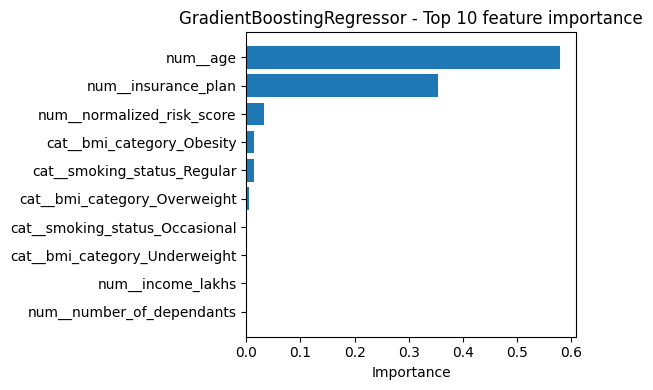

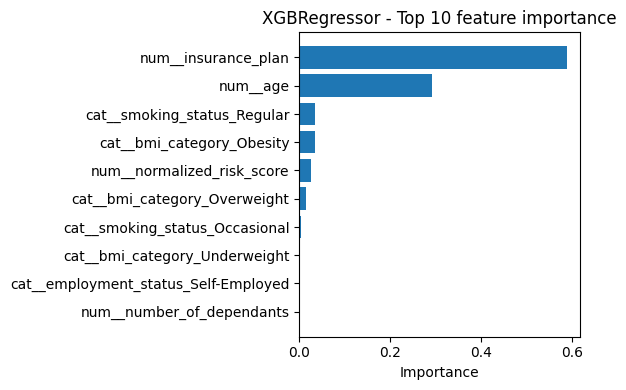

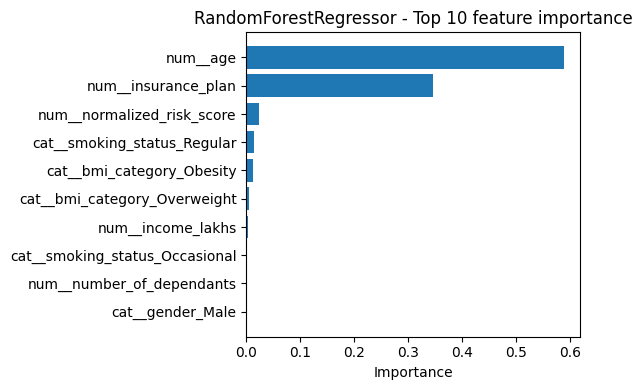

In [12]:
X_val, y_val = X_test, y_test         

for pipe in top_pipes:
    name = pipe.named_steps["model"].__class__.__name__
    imp  = get_feature_importance(pipe, X_val, y_val)     # Series

  
    top_k = imp.head(10)[::-1]          
    fig, ax = plt.subplots(figsize=(6, 4))   
    ax.barh(top_k.index, top_k.values)      
    ax.set_title(f"{name} - Top 10 feature importance")
    ax.set_xlabel("Importance")
    ax.set_ylabel("")
    plt.tight_layout()
    plt.show()

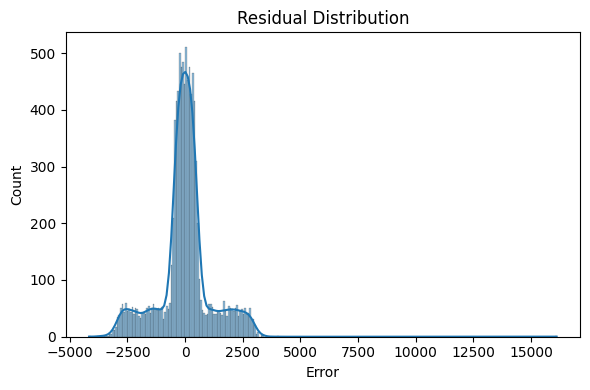

In [13]:
y_pred = results.iloc[0]["best_estimator"].predict(X_test)
residuals = y_test - y_pred

plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.xlabel("Error")
plt.tight_layout()
plt.show()


In [14]:
import joblib, pathlib, datetime as dt


MODEL_DIR = pathlib.Path.cwd().parent / "src" / "insurance" / "models"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

for row in results.itertuples():               
    name  = row.model                           # 'GBR', 'XGB', 'RandomForest'
    pipe  = row.best_estimator                 

    stamp = dt.datetime.now().strftime("%Y%m%d")
    fname = MODEL_DIR / f"premium_{name}_{stamp}.joblib"

    joblib.dump(pipe, fname)
    print("✔ saved →", fname)


✔ saved → c:\Users\USER\Desktop\projects\Health Insurance Model\src\insurance\models\premium_XGB_20250530.joblib
✔ saved → c:\Users\USER\Desktop\projects\Health Insurance Model\src\insurance\models\premium_RandomForest_20250530.joblib
✔ saved → c:\Users\USER\Desktop\projects\Health Insurance Model\src\insurance\models\premium_GBR_20250530.joblib
✔ saved → c:\Users\USER\Desktop\projects\Health Insurance Model\src\insurance\models\premium_ElasticNet_20250530.joblib
✔ saved → c:\Users\USER\Desktop\projects\Health Insurance Model\src\insurance\models\premium_Lasso_20250530.joblib
✔ saved → c:\Users\USER\Desktop\projects\Health Insurance Model\src\insurance\models\premium_Ridge_20250530.joblib
